
=== DATA PREVIEW ===
        Date  CoffeeAmount_ml   Bedtime WakeupTime  SleepQuality  EnergyLevel  \
0 2025-10-10              330  22:00:00   09:30:00             4            3   
1 2025-10-11              250  23:30:00   11:30:00             3            2   
2 2025-10-12              330  00:00:00   12:00:00             2            2   
3 2025-10-13              400  23:00:00   10:15:00             5            4   
4 2025-10-14                0  22:00:00   09:30:00             3            4   

   ExamDay  
0        0  
1        0  
2        0  
3        0  
4        0  

Fetching weather data from the API...
Weather precipitation column has been added!

=== MISSING VALUE CHECK ===
Date                     0
CoffeeAmount_ml          0
Bedtime                  0
WakeupTime               0
SleepQuality             0
EnergyLevel              0
ExamDay                  0
Weather_Precipitation    0
SleepDuration_hr         0
Weekday                  0
dtype: int64


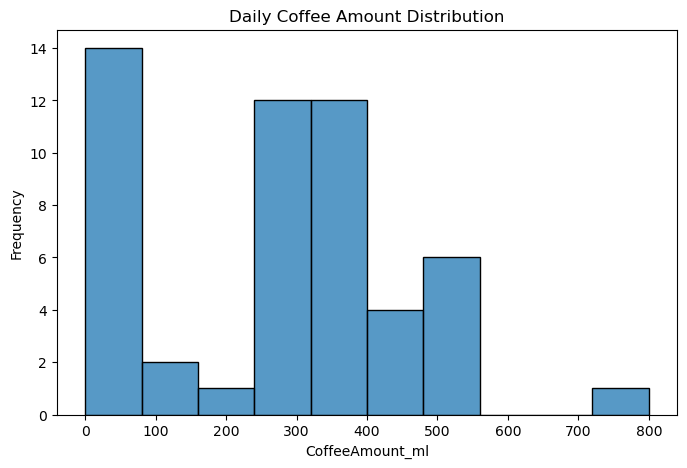

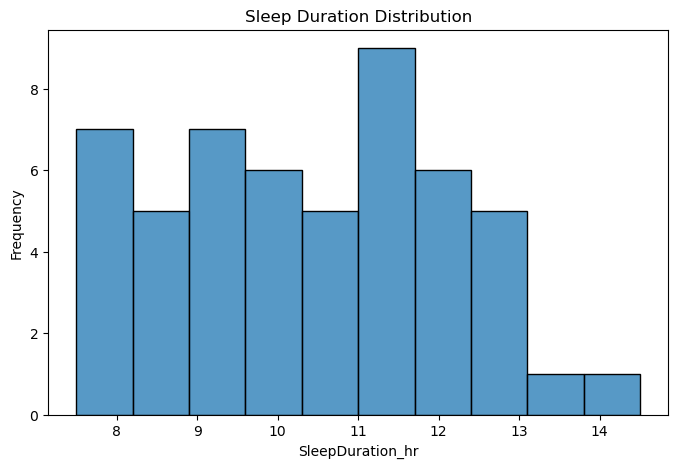

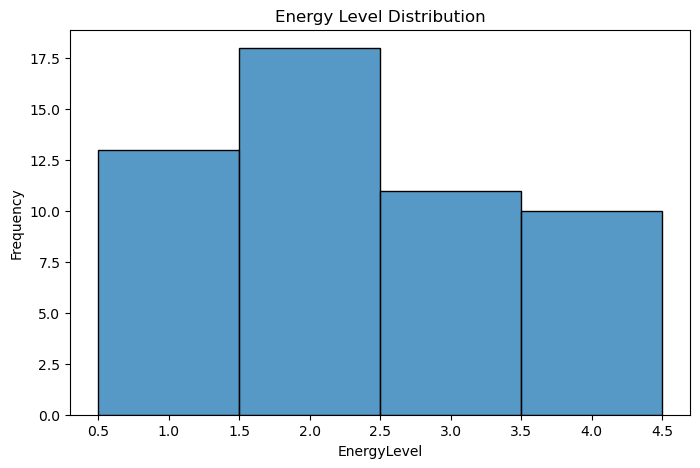

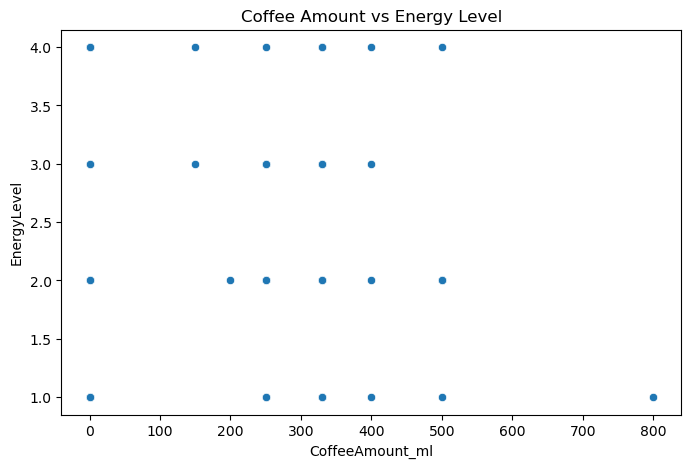

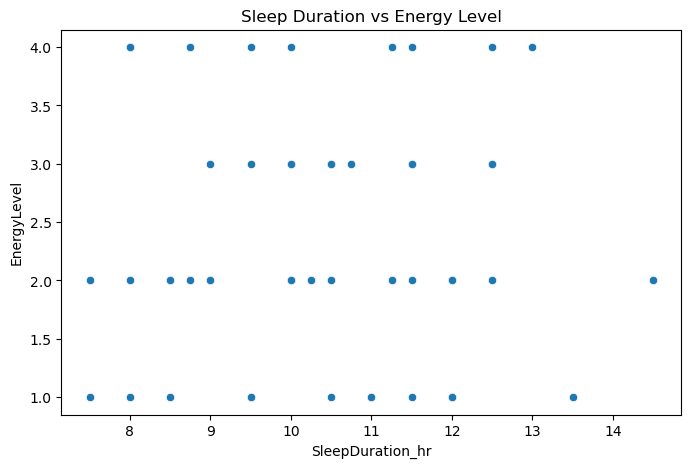

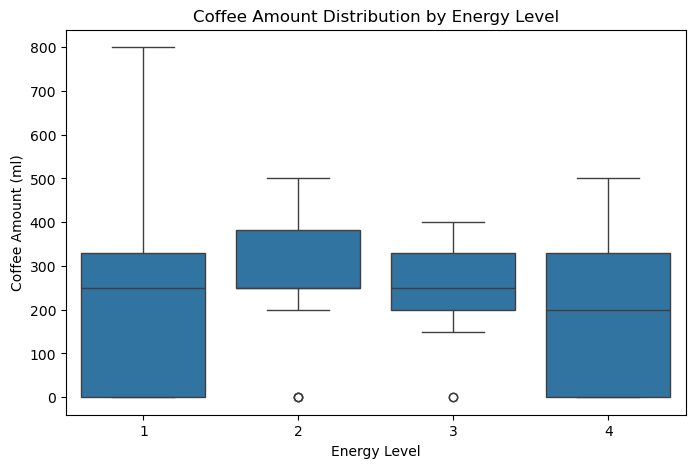

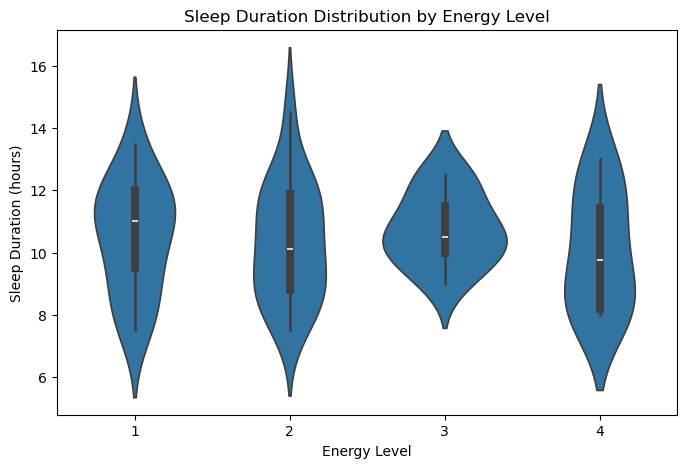

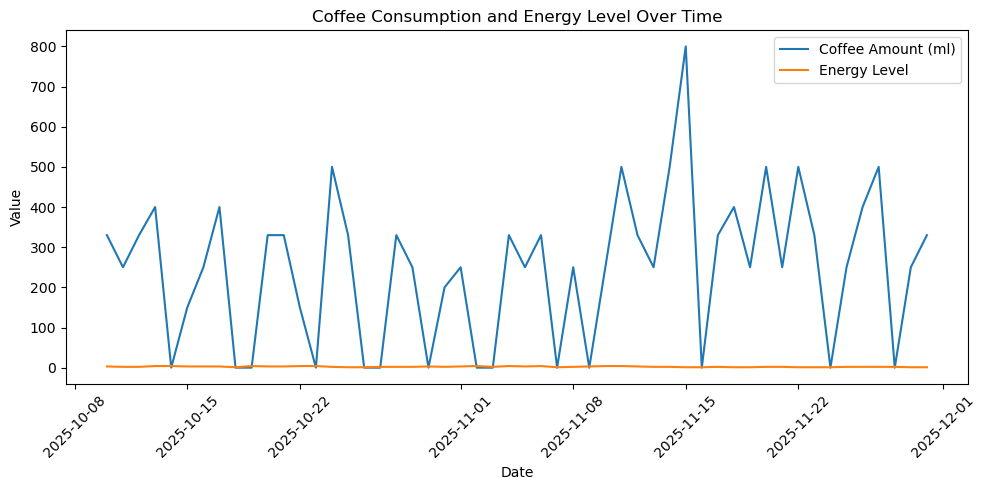

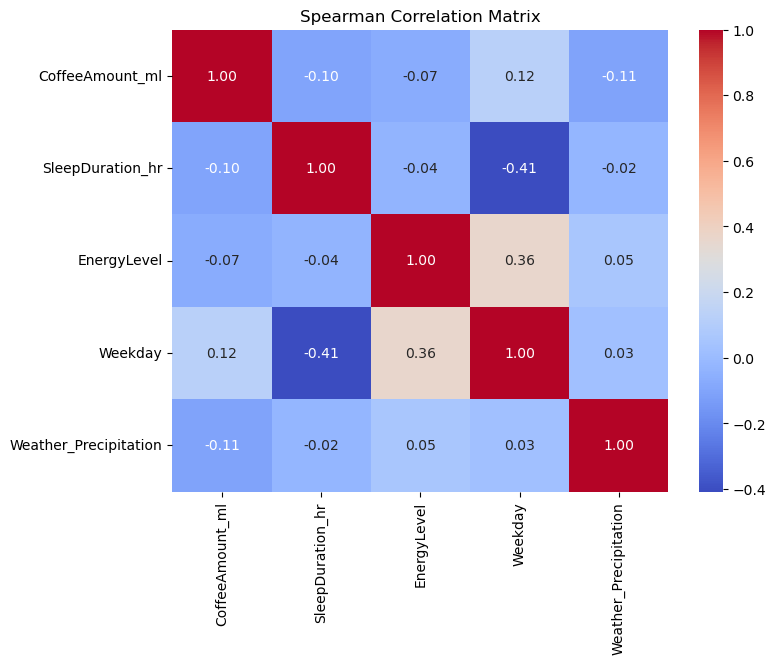

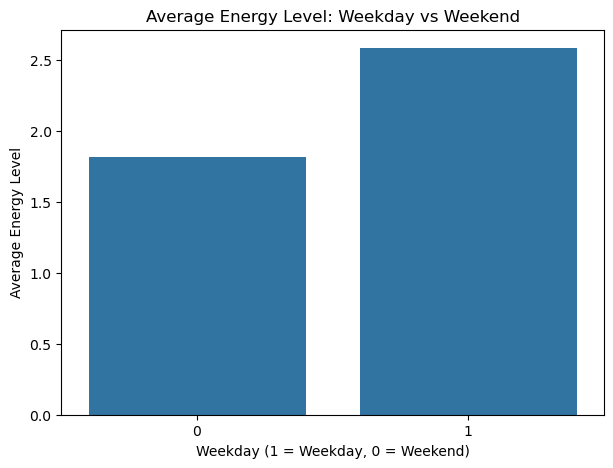

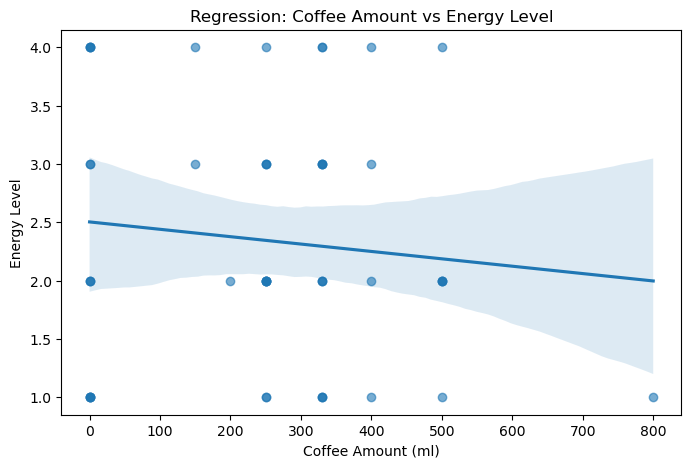


=== CORRELATIONS ===
Pearson r = -0.110, p = 0.438
Spearman rho = -0.068, p = 0.631

=== HYPOTHESIS TEST RESULTS ===
Pearson: Fail to reject H0 -> The effect of coffee amount on energy level is not statistically significant.
Spearman: Fail to reject H0 -> The effect of coffee amount on energy level is not statistically significant.

New CSV file created: coffee_processed_output.csv

=== MACHINE LEARNING (Classification) ===
Target: EnergyLevel
ML dataset size: 52 rows

--- Logistic Regression Results ---
Accuracy: 0.154
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.20      0.20      0.20         5
           3       0.00      0.00      0.00         3
           4       0.33      0.50      0.40         2

    accuracy                           0.15        13
   macro avg       0.13      0.17      0.15        13
weighted avg       0.13      0.15      0.14        13



c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


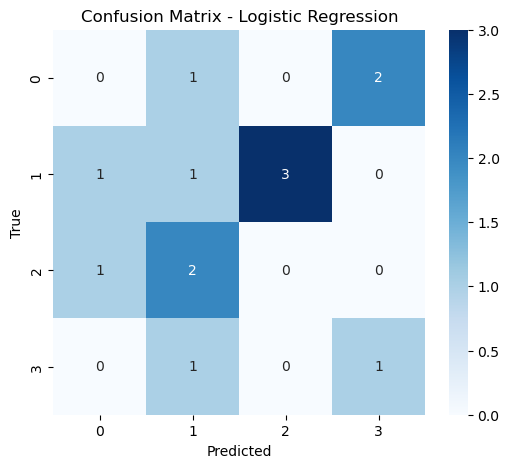


--- Random Forest Results ---
Accuracy: 0.077
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.12      0.20      0.15         5
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2

    accuracy                           0.08        13
   macro avg       0.03      0.05      0.04        13
weighted avg       0.05      0.08      0.06        13



c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


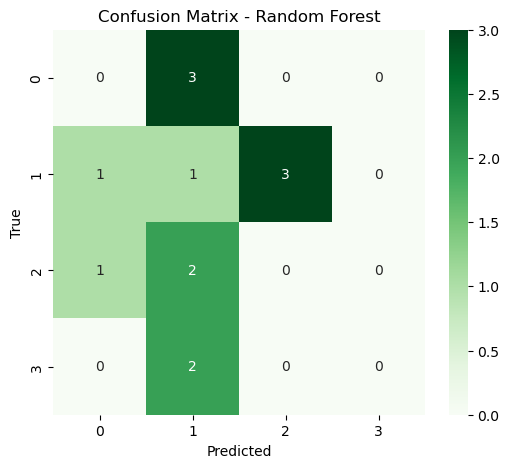


Feature Importances (Random Forest):
                 Feature  Importance
1       SleepDuration_hr    0.436757
0        CoffeeAmount_ml    0.285737
2                Weekday    0.184020
3  Weather_Precipitation    0.093487


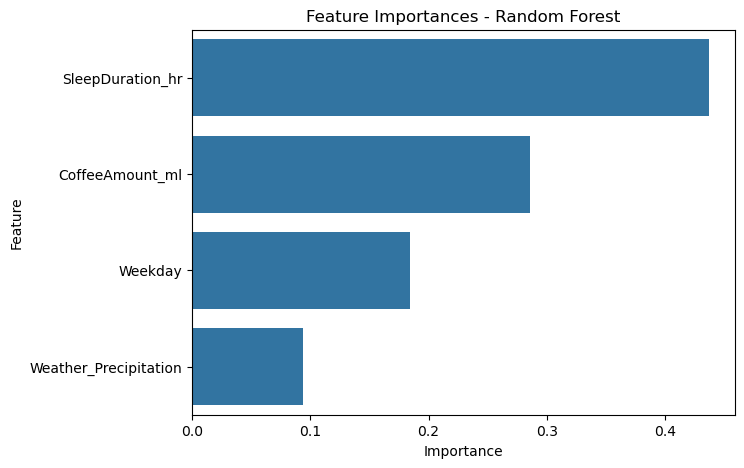

In [5]:
# ============================================
# Coffee-Sleep Data Analysis for DSA210 Project
# ============================================

import pandas as pd
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# ------------------------------------------------
# 1) Read the Excel file
# ------------------------------------------------

# Excel file name (your file: coffe_consumption.xlsx)
df = pd.read_excel("coffe_consumption.xlsx")

# Convert Date column to datetime format (safe even if already datetime)
df["Date"] = pd.to_datetime(df["Date"])

print("\n=== DATA PREVIEW ===")
print(df.head())

# ------------------------------------------------
# 2) Get Weather Condition (Precipitation) via API
# ------------------------------------------------

api_key = "FNMPG7K6B8L9Z5G3TPQA9JSHS"  # PUT YOUR OWN VISUAL CROSSING API KEY HERE
city = "Istanbul,Turkey"

precip_list = []

print("\nFetching weather data from the API...")

for date in df["Date"]:
    date_api_format = date.strftime("%Y-%m-%d")
    url = (
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/"
        f"timeline/{city}/{date_api_format}/{date_api_format}"
        f"?unitGroup=metric&key={api_key}&include=days"
    )

    try:
        resp = requests.get(url, timeout=20)
        resp.raise_for_status()
        data = resp.json()
        precip = data["days"][0].get("precip", 0)
    except Exception as e:
        print(f"Warning: Weather data could not be retrieved for {date_api_format}: {e}")
        precip = 0

    precip_flag = 1 if precip > 0 else 0
    precip_list.append(precip_flag)

df["Weather_Precipitation"] = precip_list
print("Weather precipitation column has been added!")

# ------------------------------------------------
# 3) Compute SleepDuration_hr
# ------------------------------------------------

def parse_time(t):
    """
    t can be:
      - NaN
      - string ('22:00:00' or '22:00')
      - datetime.time
    Converts everything to a datetime object on an arbitrary date.
    """
    if pd.isna(t):
        return None

    # If it's a datetime.time-like object
    if hasattr(t, "hour") and hasattr(t, "minute") and not isinstance(t, str):
        return datetime(2000, 1, 1, t.hour, t.minute, getattr(t, "second", 0))

    s = str(t)

    for fmt in ("%H:%M:%S", "%H:%M"):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue

    return None

def calc_sleep_duration(row):
    bedtime = parse_time(row["Bedtime"])
    wakeup = parse_time(row["WakeupTime"])

    # If either is missing, duration cannot be computed
    if bedtime is None or wakeup is None:
        return None

    # Overnight sleep case (e.g., 23:00 -> 07:00)
    if wakeup <= bedtime:
        wakeup += timedelta(days=1)

    duration_hours = (wakeup - bedtime).total_seconds() / 3600
    return duration_hours

df["SleepDuration_hr"] = df.apply(calc_sleep_duration, axis=1)

# ------------------------------------------------
# 4) Add Weekday column (1 = weekday, 0 = weekend)
# ------------------------------------------------

df["Weekday"] = df["Date"].dt.weekday.apply(lambda x: 1 if x < 5 else 0)

# If ExamDay already exists in your Excel, you can use it directly.
# Otherwise, define it here if you want:
# exam_days = ["2025-10-20", "2025-11-05"]
# df["ExamDay"] = df["Date"].dt.strftime("%Y-%m-%d").apply(lambda x: 1 if x in exam_days else 0)

# ------------------------------------------------
# 5) Check missing values
# ------------------------------------------------

print("\n=== MISSING VALUE CHECK ===")
print(df.isna().sum())

# ------------------------------------------------
# 6) EDA – Visualizations
# ------------------------------------------------

# Histogram: Coffee amount
plt.figure(figsize=(8, 5))
sns.histplot(df["CoffeeAmount_ml"], bins=10)
plt.title("Daily Coffee Amount Distribution")
plt.xlabel("CoffeeAmount_ml")
plt.ylabel("Frequency")
plt.show()

# Histogram: Sleep duration
plt.figure(figsize=(8, 5))
sns.histplot(df["SleepDuration_hr"], bins=10)
plt.title("Sleep Duration Distribution")
plt.xlabel("SleepDuration_hr")
plt.ylabel("Frequency")
plt.show()

# Histogram: Energy level
plt.figure(figsize=(8, 5))
sns.histplot(df["EnergyLevel"], bins=5, discrete=True)
plt.title("Energy Level Distribution")
plt.xlabel("EnergyLevel")
plt.ylabel("Frequency")
plt.show()

# Scatter: Coffee vs Energy
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="CoffeeAmount_ml", y="EnergyLevel")
plt.title("Coffee Amount vs Energy Level")
plt.xlabel("CoffeeAmount_ml")
plt.ylabel("EnergyLevel")
plt.show()

# Scatter: Sleep vs Energy
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="SleepDuration_hr", y="EnergyLevel")
plt.title("Sleep Duration vs Energy Level")
plt.xlabel("SleepDuration_hr")
plt.ylabel("EnergyLevel")
plt.show()

# ---------- NEW PLOTS (More plot types) ----------

# Boxplot: Coffee amount by Energy level
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="EnergyLevel", y="CoffeeAmount_ml")
plt.title("Coffee Amount Distribution by Energy Level")
plt.xlabel("Energy Level")
plt.ylabel("Coffee Amount (ml)")
plt.show()

# Violin plot: Sleep duration by Energy level
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="EnergyLevel", y="SleepDuration_hr")
plt.title("Sleep Duration Distribution by Energy Level")
plt.xlabel("Energy Level")
plt.ylabel("Sleep Duration (hours)")
plt.show()

# Time series: Coffee & Energy over time (sorted by date)
df_sorted = df.sort_values("Date").copy()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_sorted, x="Date", y="CoffeeAmount_ml", label="Coffee Amount (ml)")
sns.lineplot(data=df_sorted, x="Date", y="EnergyLevel", label="Energy Level")
plt.title("Coffee Consumption and Energy Level Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap: Correlation matrix (Spearman)
corr_cols = ["CoffeeAmount_ml", "SleepDuration_hr", "EnergyLevel", "Weekday", "Weather_Precipitation"]
corr_matrix = df[corr_cols].corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

# Bar plot: Average Energy level (Weekday vs Weekend)
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x="Weekday", y="EnergyLevel", estimator="mean", errorbar=None)
plt.title("Average Energy Level: Weekday vs Weekend")
plt.xlabel("Weekday (1 = Weekday, 0 = Weekend)")
plt.ylabel("Average Energy Level")
plt.show()

# Regression plot: Coffee vs Energy
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="CoffeeAmount_ml", y="EnergyLevel", scatter_kws={"alpha": 0.6})
plt.title("Regression: Coffee Amount vs Energy Level")
plt.xlabel("Coffee Amount (ml)")
plt.ylabel("Energy Level")
plt.show()

# ------------------------------------------------
# 7) Correlation + Hypothesis Testing
# ------------------------------------------------

print("\n=== CORRELATIONS ===")

# Drop missing rows for correlation calculations
corr_df = df[["CoffeeAmount_ml", "EnergyLevel"]].dropna()

pearson_r, pearson_p = pearsonr(corr_df["CoffeeAmount_ml"], corr_df["EnergyLevel"])
spearman_rho, spearman_p = spearmanr(corr_df["CoffeeAmount_ml"], corr_df["EnergyLevel"])

print(f"Pearson r = {pearson_r:.3f}, p = {pearson_p:.3f}")
print(f"Spearman rho = {spearman_rho:.3f}, p = {spearman_p:.3f}")

print("\n=== HYPOTHESIS TEST RESULTS ===")
if pearson_p < 0.05:
    print("Pearson: Reject H0 -> Coffee amount has a statistically significant effect on energy level.")
else:
    print("Pearson: Fail to reject H0 -> The effect of coffee amount on energy level is not statistically significant.")

if spearman_p < 0.05:
    print("Spearman: Reject H0 -> Coffee amount has a statistically significant effect on energy level.")
else:
    print("Spearman: Fail to reject H0 -> The effect of coffee amount on energy level is not statistically significant.")

# ------------------------------------------------
# 8) Save the processed data as CSV
# ------------------------------------------------

output_name = "coffee_processed_output.csv"
df.to_csv(output_name, index=False)
print(f"\nNew CSV file created: {output_name}")

# ------------------------------------------------
# 9) Machine Learning: Predict EnergyLevel (Classification)
# ------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("\n=== MACHINE LEARNING (Classification) ===")
print("Target: EnergyLevel")

# ---------
# Feature set
# ---------
# You can add/remove features here depending on what exists in your dataset.
feature_cols = [
    "CoffeeAmount_ml",
    "SleepDuration_hr",
    "Weekday",
    "Weather_Precipitation"
]

# Keep only rows where target exists
ml_df = df[feature_cols + ["EnergyLevel"]].dropna(subset=["EnergyLevel"]).copy()

X = ml_df[feature_cols]
y = ml_df["EnergyLevel"].astype(int)  # ensure integer classes

print(f"ML dataset size: {len(ml_df)} rows")

# Train-test split
# stratify helps preserve class distribution if EnergyLevel has multiple classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_features = feature_cols

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ],
    remainder="drop"
)

# ------------------------
# Model 1: Logistic Regression (baseline)
# ------------------------
logreg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000, multi_class="auto"))
])

logreg_model.fit(X_train, y_train)
y_pred_lr = logreg_model.predict(X_test)

print("\n--- Logistic Regression Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------------
# Model 2: Random Forest (often stronger for small tabular datasets)
# ------------------------
# RandomForest does not require scaling, but we still impute missing values
rf_preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features)
    ],
    remainder="drop"
)

rf_model = Pipeline(steps=[
    ("preprocess", rf_preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n--- Random Forest Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature importance (Random Forest)
rf_est = rf_model.named_steps["model"]
importances = rf_est.feature_importances_

fi_df = pd.DataFrame({
    "Feature": numeric_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\nFeature Importances (Random Forest):")
print(fi_df)

plt.figure(figsize=(7, 5))
sns.barplot(data=fi_df, x="Importance", y="Feature")
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()